# 先端機械学習2022中間レポート Problem 3
hinge損失+L2正則化を用いた二値分類サポートベクターマシンを、双対問題を射影勾配法（Projected Gradient）を用いて解く方法で作成し、ラグランジュ双対関数の値と元の目的関数の値が漸近する（duality gapがゼロに近づく）ことを確認する。

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def svm(x, y, lam):
    """
    SVMの双対問題をProjectedGradientで解く
    """
    MAX_ITERATION = 10000
    n = x.shape[0]
    d = x.shape[1]+1
    x = np.hstack([x, np.ones((n,1))]) # オフセットのために各列に1を追加する
    X = y[:,np.newaxis]*x
    K = X @ X.T
    alpha = np.zeros(n) # 最適化するパラメータ
    w = 1/2/lam * np.dot(X.T, alpha)
    # 学習率
    L = 1/2/lam * np.max(np.abs(np.linalg.eig(K)[0]))
    eta = 1/L
    # [0,1]直方体への射影
    projection = np.vectorize(lambda x: 1 if x >= 1 else (0 if x <= 0 else x))
    
    alpha_history = []
    w_history = []
    dual_score_history = []
    hinge_loss_history = []
    for _ in range(MAX_ITERATION):
      # 記録
      dual_score = -1/4/lam * np.dot(alpha.T, np.dot(K, alpha)) + np.sum(alpha)
      hinge_loss = \
        np.sum(np.max(1 - np.dot(X, w)[:,np.newaxis], initial=0, axis=1)) \
        + lam * np.dot(w.T, w)
      alpha_history.append(alpha)
      w_history.append(w)
      dual_score_history.append(dual_score)
      hinge_loss_history.append(hinge_loss)

      # 更新
      grad = 1/2/lam * np.dot(K, alpha) - 1
      alpha = projection(alpha - eta * grad)
      w = 1/2/lam * np.dot(X.T, alpha)

    return w, w_history, dual_score_history, hinge_loss_history

In [8]:
def generate_data():
  # toy dataset 4
  n = 200
  x = 3 * (np.random.rand(n, 4) - 0.5)
  y = (2 * x[:,0] - 1 * x[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
  y = 2 * y - 1
  return n, x, y
def plot_2Ddata(x, y):
  # 二次元データ点の描画
  plt.plot(np.extract(y>0,x[:,0]),np.extract(y>0,x[:,1]), 'x')
  plt.plot(np.extract(y<0,x[:,0]),np.extract(y<0,x[:,1]), 'o')

Text(0, 0.5, 'x2')

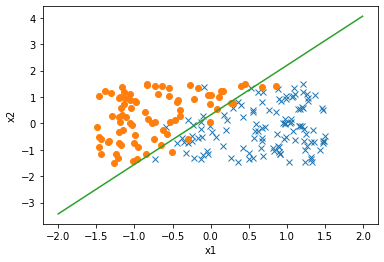

In [9]:
# 学習の実行
np.random.seed(1024)

MAX_ITERATION = 10000
n,x,y = generate_data()
lam = 0.01

# 第二成分までを使ったときの決定境界を描画（実際にはw[2:]は非ゼロ）
plot_2Ddata(x, y)
xs = np.arange(-2,2,0.01)
w, w_history, dual_score_history, hinge_loss_history = svm(x,y,lam)
ys = (-w[0]*xs-w[-1])/w[1]
plt.plot(xs, ys)
plt.xlabel("x1")
plt.ylabel("x2")

Text(0.5, 0, 'iteration')

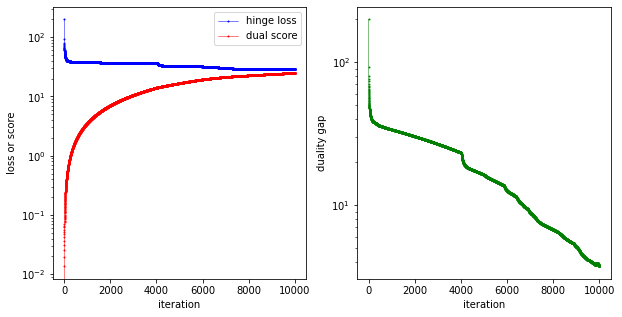

In [11]:
# hinge損失の和、双対問題のスコアを描画し、duality gapが0に近づくことを確認
hinge_loss_history = np.array(hinge_loss_history)
dual_score_history = np.array(dual_score_history)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hinge_loss_history, "bo-", linewidth=0.5, markersize=1, label="hinge loss")
ax1.plot(dual_score_history, "ro-", linewidth=0.5, markersize=1, label="dual score")
ax1.set_yscale("log")
ax1.set_ylabel("loss or score")
ax1.set_xlabel("iteration")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(hinge_loss_history-dual_score_history, "go-", linewidth=0.5, markersize=1, label="duality gap")
ax2.set_yscale("log")
ax2.set_ylabel("duality gap")
ax2.set_xlabel("iteration")